In [1]:
#### -- 1-1. 모듈 불러오기 -- ####
# Pytorch 라이브러리 불러오기
import torch
# 딥러닝 네트워크의 기본 구성요소를 포함한 torch.nn 모듈 불러오기
import torch.nn as nn
# 딥러닝에 자주 사용되는 함수가 포함된 모듈 불러오기
import torch.nn.functional as F
# 가중치 추정에 필요한 최적화 알고리즘 모듈 불러오기
import torch.optim as optim
# datasets, transforms 모듈 불러오기
from torchvision import datasets, transforms

# 시각화 모듈 불러오기
from matplotlib import pyplot as plt
# 주피터 노트북 사용자는 코드 실행 시 브라우저에서 바로 그림을 보려면
# 꼭 필요한 코드입니다.
%matplotlib inline

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#### -- 1-2. 분석 환경 설정 -- ####
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


In [3]:
#### -- 1-3. Hyper-parameter 지정 -- ####
# 모델 가중치를 한 번 업데이트시킬 떄 사용되는 샘플 단위 개수
# batch_size == 미니 배치 사이즈
batch_size = 50
# 가중치 업데이트의 정도(학습률)
learning_rate = 0.0001
# 학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수
epoch_num = 15

In [4]:
#### -- 2-1. MNIST 데이터 불러오기 -- ####
train_data = datasets.MNIST(root='./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

100%|████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 34858832.52it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 13968957.96it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

number of training data:  60000
number of test data:  10000


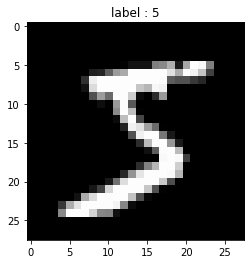

In [5]:
#### -- 2-2. MNIST 데이터 확인하기 -- ####
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [6]:
#### -- 2-3. Mini-Batch 구성하기 -- ####
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)),
                                     len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]',
                                     str(type(first_batch[0])),
                                     first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]',
                                     str(type(first_batch[1])),
                                     first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [7]:
#### -- 3-1. CNN 구조 설계하기 -- ####
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
#### -- 3-2. Optimizer 및 손실함수 정의 -- ####
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [9]:
#### -- 3-3. 설계한 CNN 모형 확인하기 -- ####
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
#### -- 3-4. 모델 학습하기 -- ###
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 1000	Loss: 0.476
Train Step: 2000	Loss: 0.256
Train Step: 3000	Loss: 0.135
Train Step: 4000	Loss: 0.142
Train Step: 5000	Loss: 0.166
Train Step: 6000	Loss: 0.262
Train Step: 7000	Loss: 0.038
Train Step: 8000	Loss: 0.015
Train Step: 9000	Loss: 0.041
Train Step: 10000	Loss: 0.047
Train Step: 11000	Loss: 0.039
Train Step: 12000	Loss: 0.084
Train Step: 13000	Loss: 0.107
Train Step: 14000	Loss: 0.031
Train Step: 15000	Loss: 0.034
Train Step: 16000	Loss: 0.034
Train Step: 17000	Loss: 0.017
Train Step: 18000	Loss: 0.044


In [11]:
#### -- 4. 모델 평가하기 -- ###
model.eval()
correct = 0
for data, target in test_loader:
    #     data, target = Variable(data, volatile=True), Variable(target)
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100. * correct /
                                           len(test_loader.dataset)))

Test set: Accuracy: 98.98%


In [12]:
correct

tensor(9898, device='cuda:0')

In [14]:
prediction.eq(target.data)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True], device='cuda:0')